# Reconstruction of Trajectory

by use of linear acceleration and angular velocity (IMU)

Equations and systematic procedure are mainly taken from the work **3D Kinematics** by Thomas Haslwanter (MME script for 1st semester 3D Kinematics).


In [1]:
import skinematics as skin
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from scipy.signal import savgol_filter
import functionsMasterProjectMeinhart as fmpm

In [3]:
#%matplotlib inline
%matplotlib auto

Using matplotlib backend: TkAgg


**Some general definitons:**

In [2]:
sampling_rate = 256 # [Hz] sampling rate of IMU
delta_t = 1/sampling_rate # [s]


pos_pre = np.array([0,0,0]) # [m] initial value
vel_pre = np.array([0,0,0]) # [m/s] initial value
q_vec_pre = np.array([0,0,0]) # initial or previous quaternion (vector part)


# arbitrary values for testing:
angular_vel = np.array([0,0,90]) * np.pi/180 # [rad/s]
acc_obj_measured = np.array([0.1, 0.3, 1]) * 9.81 # g --> [m/s^2]

acc_space_gravity = np.array([0, 0, 1]) * 9.81 # initial measurement [m/s^2]


## Orientation in Space

First we have to find the new orientation of the object with respect to space:

$\textbf{R}_{object}^{space} = \textbf{R}_{object, previous}^{space} \cdot \Delta \textbf{R}^{object}$

This is easier to do by means of quaternions, because we get the angular velocity $\vec{\omega}^{object}$ for each step directly from the sensor:

$q_{new}^{space} = q_{previous}^{space} \circ \Delta q^{object}$

$\Delta \vec{q}^{object} = \vec{n}(t) \: sin\left(\frac{\Delta\phi}{2}\right) = \frac{\vec{\omega}^{object}}{|\vec{\omega}^{object}|} \: sin\left(\frac{|\vec{\omega}^{object}| \Delta t}{2}\right)$

Let's use the library for scientific data analysis $\textbf{skinematics} \rightarrow$ http://work.thaslwanter.at/skinematics/html/

In [6]:
angular_vel_abs = np.linalg.norm(angular_vel) # absolute value of current angular velocity

# avoid division by zero (or value close to zero)
if angular_vel_abs < 0.00001 and angular_vel_abs > -0.00001:
    q_vec_new = q_vec_pre

else:
    delta_q_vec = angular_vel/angular_vel_abs * np.sin(angular_vel_abs*delta_t/2)
    q_vec_new = skin.quat.q_mult(q_vec_pre, delta_q_vec)

Now we know the current orientation by means of the quaternion $q^{space}_{new}$, consequently we can calculate the corresponding rotation matrix $\textbf{R}^{space}_{object}$.

That is exactly what we wanted to achieve at this step. The calculation itself is a little bit tricky, so let's again use a $skinemtaics$ function.

In [7]:
R_space_obj = skin.quat.convert(q_vec_new, to='rotmat')
R_space_obj

array([[ 0.99998118, -0.00613588,  0.        ],
       [ 0.00613588,  0.99998118,  0.        ],
       [ 0.        ,  0.        ,  1.        ]])

## Position in Space

Let's first define the space (reference frame) by the initial (starting) position.

As a next step the following formula can be used to calculate the object's linear acceleration for movement in the defined space:

$\vec{acc}^{space}_{movement} = \textbf{R}_{object}^{space} \cdot \vec{acc}^{object}_{measurement} - \vec{acc}^{space}_{gravity}$

As can be seen, now the previously calculated rotation matrix $\textbf{R}_{object}^{space}$ is used.

Furthermore, it can be seen that the formula above already eliminates the influence of gravity. But so far, the exact orientation of the gravity vector is not known in the defined space.

*The question is: how to get the orientation of gravity in the defined space?*

I think we have to make an assumption here: Linear velocity is zero in the beginning, the sensor does not move.

$\vec{pos}^{space}_{start} = \begin{pmatrix} 0 \\ 0 \\ 0 \end{pmatrix}m$

When eliminating the influence of gravity, the position immediately after performing an exercise should be quite similar to the starting position. Hence, by deliberately keeping the influence of gravity at calculating the trajectory we should end up somewhere just above the starting position. Consequently, it should be possible first to calculate the position without eliminating the influence of gravity so that we can look at the resulting position, which then gives us the direction of gravity in our defined space. Moreover, we can also quantitative determine the influence of gravity, because we know the distance traveled as well as the time.

$\vec{acc}^{space}_{movement} = \textbf{R}_{object}^{space} \cdot \vec{acc}^{object}_{measurement}$


In [8]:
acc_space_movement = np.dot(R_space_obj, acc_obj_measured)
acc_space_movement 

array([0.96292362, 2.9489639 , 9.81      ])

In order to calculate now the new position and velocity in the defined space the following equations can be used:

$\vec{vel}^{space}_{new} = \vec{vel}^{space}_{pre} + \vec{acc}^{space}_{movement}*\Delta t$

$\vec{pos}^{space}_{new} = \vec{pos}^{space}_{pre} + \vec{vel}^{space}_{pre}*\Delta t + \frac{\vec{acc}^{space}_{movement}}{2}*\Delta t^2$

In [9]:
vel_new = vel_pre + acc_space_movement*delta_t
print("Velocity: ", vel_new)

pos_new = pos_pre +  vel_pre*delta_t + 0.5*acc_space_movement*delta_t**2
print("Position: ", pos_new)

Velocity:  [0.00376142 0.01151939 0.03832031]
Position:  [7.34652423e-06 2.24988091e-05 7.48443604e-05]


Now we are done with updating orientation and position for this step, thus we can fetch the next values from the IMU and restart again from 1.1.

## Using an Upright Space

Using an upright space shall mean that gravity points in z-direction $\rightarrow$ $\vec{acc}^{upright}_{gravity} = \begin{pmatrix} 0 \\ 0 \\ 9.81 \end{pmatrix}\frac{m}{s^2}$

As described before we get the gravity vector in the previously defined space from the final position and the duration of an exercise.

$$\vec{acc}^{space}_{gravity} =  \frac{2}{(t_{stop}-t_{start})^2} \cdot \vec{pos}^{space}_{final}$$

If we now want to find the matrix $\textbf{R}^{upright}_{space}$, which rotates points from the initial space into an upright space, we can proceed as follows:

$\vec{acc}^{space}_{gravity,norm} = \frac{1}{|\vec{acc}^{space}_{gravity}|} \cdot \vec{acc}^{space}_{gravity}$

$\vec{v} = \vec{acc}^{space}_{gravity,norm} \times \begin{pmatrix} 0 \\ 0 \\ 1 \end{pmatrix}$

$s = |\vec{v}| \quad$ ... sine of angle

$c = \vec{acc}^{space}_{gravity,norm} \cdot \begin{pmatrix} 0 \\ 0 \\ 1 \end{pmatrix} \quad$ ... cosine of angle

$[v]_{\times} \quad$ ... skew-symmetric cross-product matrix of $\vec{v}$

$[v]_{\times} = \begin{bmatrix} 0 & -v_3 & v_2\\ v_3 & 0 & -v_1 \\ -v_2 & v_1 & 0 \end{bmatrix}$

$\textbf{R}^{upright}_{space} = \textbf{I} + [v]_{\times} + [v]_{\times}^2 \frac{1-c}{s^2}$

https://math.stackexchange.com/questions/180418/calculate-rotation-matrix-to-align-vector-a-to-vector-b-in-3d

In [ ]:
# CODE NOT EXECUTABLE --> JUST A TEMPLATE FOR A FUNCTION (see below)

# bring velocity and position in an upright frame:
    
acc_gravity = np.array(pos_init_space[-1]) *2 / (delta_t*num_steps)**2

acc_gravity_abs = np.linalg.norm(acc_gravity)
acc_gravity_norm = np.array(acc_gravity) / acc_gravity_abs # normalize

vec_upright = np.array([0,0,1])

v = np.cross(acc_gravity_norm, vec_upright)
s = np.linalg.norm(v) # sine of angle
c = np.dot(acc_gravity_norm, vec_upright) # cosine of angle

# skew-symmetric cross-product matrix of v
Vx = np.array([[ 0,   -v[2], v[1] ],
               [ v[2], 0 ,  -v[0] ],
               [-v[1], v[0], 0    ]])

R_upright_init = np.identity(3) + Vx + np.dot(Vx,Vx) * (1-c)/s**2

# rotate velocity and position profile into upright frame
vel_upright = np.array([np.dot(R_upright_init, vel_init_space[ii]) for ii in range(num_steps+1)])
pos_upright = np.array([np.dot(R_upright_init, pos_init_space[ii]) for ii in range(num_steps+1)])


## Eliminating Influence of Gravity

Now we can simply eliminate the influence of gravity on the velocity and position profile.

In [ ]:
# CODE NOT EXECUTABLE --> JUST A TEMPLATE FOR A FUNCTION (see below)

# eliminate influence of gravity:
for ii in np.arange(num_steps+1):
    vel_upright[ii] = vel_upright[ii] - np.array([0,0,acc_gravity_abs])*(delta_t*ii)
    pos_upright[ii] = pos_upright[ii] - 0.5*np.array([0,0,acc_gravity_abs])*(delta_t*ii)**2


## Function to calculate Trajectory

It would be nice to have a function, which automatically calculates orientation and trajectory for a whole set of linear acceleration and angular velocity data.

In [3]:
def calc_trajectory(acc_lin_g, vel_ang_degps, sampling_rate=256):
    '''
    This function calculates the trajectory in an upright frame (z-axis aligned with gravity)
    by means of a set of linear acceleration [g] and angular velocity [deg/s] data.
    The sampling rate has to be given in Hz.
    
    Inputs
    ------
    acc_lin_g: linear acceleration [g]
    
    vel_ang_degps: angular velocity [deg/s]
    
    sampling_rate: sampling rate of the measured signals in Hz
    
    
    Returns
    -------
    Dictionary with upright position, 
                    velocity,
                    orientation (vector-part of quaternion) and
                    rotation matrix from initial orientation to upright space
    '''
    
    
    g_mps2 = 9.80665 # gravity [m/s^2]
    
    acc_lin = np.array(acc_lin_g) * g_mps2 # linear acceleration in m/s^2
    
    vel_ang = np.array(vel_ang_degps) * np.pi/180 # angular velocity in rad/s
    
    delta_t = 1/sampling_rate
    
    
    # check number of data points
    if acc_lin.ndim is 1 or vel_ang.ndim is 1:
        num_steps = 1
    elif np.shape(acc_lin)[0] <= np.shape(vel_ang)[0]:
        num_steps = np.shape(acc_lin)[0]
    else:
        num_steps = np.shape(vel_ang)[0]
    
    # reserve memory for position and orientation vectors
    #    --> one step more, because of initial condition
    pos_init_space = np.zeros((num_steps+1, 3))
    vel_init_space = np.zeros((num_steps+1, 3))
    q_vec = np.zeros((num_steps+1, 3)) # vector part of quaternion
         
    
    for ii in range(num_steps):
        
        omega_abs = np.linalg.norm(vel_ang[ii])
        
        # avoid division by zero (or value close to zero)
        if omega_abs < 0.00001 and omega_abs > -0.00001:
            q_vec[ii+1] = q_vec[ii]
        
        else:
            # calculate new quaternion (new orientation)
            delta_q_vec = vel_ang[ii]/omega_abs * np.sin(omega_abs*delta_t/2)
            q_vec[ii+1] = skin.quat.q_mult(q_vec[ii], delta_q_vec)
        
        # get corresponding rotation matrix for new orientation
        R_init_space_obj = skin.quat.convert(q_vec[ii+1] , to='rotmat')
        
        # get current acceleration in initial space
        acc_init_space = np.dot(R_init_space_obj, acc_lin[ii])
        
        # calculate linear velocity for next point in initial space
        vel_init_space[ii+1] = vel_init_space[ii] + acc_init_space*delta_t
        
        # calculate position for next point in initial space
        pos_init_space[ii+1] = pos_init_space[ii] +  vel_init_space[ii]*delta_t + 0.5*acc_init_space*delta_t**2
    
    
    # calculate gravity by means of final position and duration
    acc_gravity = np.array(pos_init_space[-1]) *2 / (delta_t*num_steps)**2
    
    acc_gravity_abs = np.linalg.norm(acc_gravity)
    acc_gravity_norm = np.array(acc_gravity) / acc_gravity_abs # normalize
    
    vec_upright = np.array([0,0,1]) # upright vector

    v = np.cross(acc_gravity_norm, vec_upright)
    s = np.linalg.norm(v) # sine of angle
    c = np.dot(acc_gravity_norm, vec_upright) # cosine of angle

    # skew-symmetric cross-product matrix of v
    Vx = np.array([[ 0,   -v[2], v[1] ],
                   [ v[2], 0 ,  -v[0] ],
                   [-v[1], v[0], 0    ]])

    # calculate matrix for rotation from initial space to upright space
    R_upright_init = np.identity(3) + Vx + np.dot(Vx,Vx) * (1-c)/s**2
    
    # rotate velocity and position profile into upright frame
    vel_upright = np.array([np.dot(R_upright_init, vel_init_space[ii]) for ii in range(num_steps+1)])
    pos_upright = np.array([np.dot(R_upright_init, pos_init_space[ii]) for ii in range(num_steps+1)])
    
    
    # eliminate influence of gravity:  
    for ii in np.arange(num_steps+1):
        vel_upright[ii] = vel_upright[ii] - np.array([0,0,acc_gravity_abs])*(delta_t*ii)
        pos_upright[ii] = pos_upright[ii] - 0.5*np.array([0,0,acc_gravity_abs])*(delta_t*ii)**2
    
    # create dictionary for return
    data_dict = {}
    data_dict['pos'] = pos_upright
    data_dict['vel'] = vel_upright
    data_dict['q_vec'] = q_vec
    data_dict['R_upright_init'] = R_upright_init
    
    return data_dict

## Try it

In [4]:
start_min = 2
start_sec = 20 #22.1

stop_min = 2
stop_sec = 23.8 #37.1

start_time = start_min*60 + start_sec # [s]
stop_time = stop_min*60 + stop_sec # [s]

sensor_data = fmpm.get_sensor_data(in_file='Subject_01/subject01.csv',
                                   start_time=start_time,
                                   stop_time=stop_time)

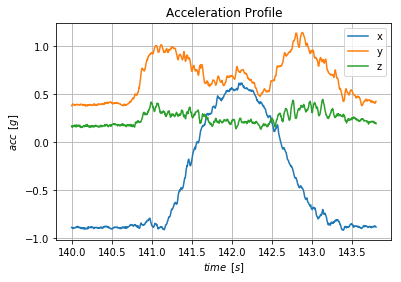

In [5]:
fmpm.plot_signal(sensor_data['Acc'],sensor_data['time'])

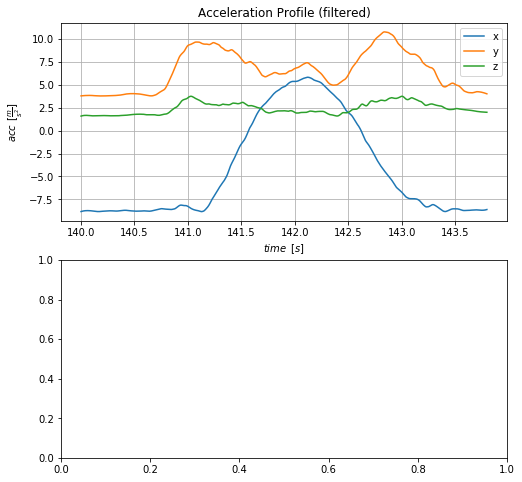

KeyError: <matplotlib.axes._subplots.AxesSubplot object at 0x0000000015A218D0>

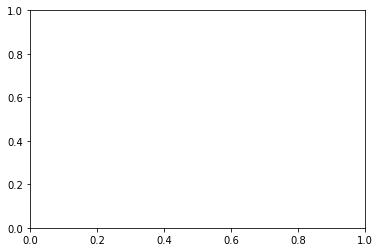

In [6]:
# filtering with Savitzky-Golay filter and plot data

window_length = 51
polyorder = 3

acc_filt = savgol_filter(sensor_data['Acc'],window_length, polyorder, axis=0)
gyr_filt = savgol_filter(sensor_data['Gyr'],window_length, polyorder, axis=0)


fig, axs = plt.subplots(2,1,figsize=(8,8))

plt.axes(axs[0])
fmpm.plot_signal(acc_filt,sensor_data['time'],
            Title='Acceleration Profile (filtered)',
            g_to_ms2=True)
plt.gca().set_xlabel('')

plt.axes(axs[1])
fmpm.plot_signal(gyr_filt,sensor_data['time'],
            Title='Angular Velocity Profile (filtered)',
            xLabel=r'$time \enspace [s]$',
            yLabel=r'$vel \enspace [\frac{deg}{s}]$')
plt.show()

In [20]:
traj_data = calc_trajectory(sensor_data['Acc'],
                            sensor_data['Gyr'],
                            sampling_rate=256)

In [23]:
traj_data_filt = calc_trajectory(acc_filt,
                                 gyr_filt,
                                 sampling_rate=sampling_rate)

In [28]:
fmpm.plot_trajectory(pos_data=traj_data_filt['pos'],
                     scale_plot_section = 0.7,
                     rotmat_upright_init=traj_data_filt['R_upright_init'],
                     scale_arrow=0.2,
                     fig_size=(8,8))